# Import Modules

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 90)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.neighbors import  KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score

from IPython.core.display import HTML

# Read Data

In [2]:
# 훈련데이터와 테스트데이터를 불러오기.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# 우리는 이것을 사용해서 전체 데이터의 일부를 빠르게 확인할 수 있다.
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 데이터셋을 탐색할 때는 전체 데이터를 사용하는 것을 추천한다.
data = pd.concat((train, test))
data['IsTrain'] = data.Survived.apply(lambda x: 0 if np.isnan(x) else 1)

In [5]:
# 우리는 훈련데이터의 컬럼과 테스트데이터의 컬럼을 비교함으로써 어떤 변수가 종속변수인지 찾을 수 있다.
print(f'Dependent variable: {set(train.columns) - set(test.columns)}')

Dependent variable: {'Survived'}


# Understand each features

우리는 몇 가지 과정을 통해 각 변수들을 자세히 이해할 것이다. 나는 당신이 전체 변수의 데이터 타입과 결측치를 빠르게 확인하고 싶다면 'info' 함수를 사용하는 것을 추천한다.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  IsTrain      1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


우리는 위 과정을 통해 다음의 사실을 알 수 있다.  
1) 총 1309개의 포인트가 존재한다.  
2) 총 11개의 변수가 존재한다.  
3) Age, Fare, Cabin은 결측치를 보유하고있다.  
4) 수치형 변수에는 PassengerId, Pclass, Age, SibSp, Parch, Fare가 있다.  
5) 카테고리형 변수에는 Name, Sex, Ticket, Cabin, Embarked가 있다.

사전에 주어진 변수 설명표를 확인해본다.

|Variable|Definition|Key|
|------|---|---|
|Survived|Survival|0 = No, 1= Yes|
|Pclass|Ticket class|1=1st, 2=2nd, 3=3rd|
|Sex|Sex||
|Age|Age in years||
|SibSp|number of siblings / spouses aboard the Titanic||
|Parch|number of parents / children aboard the Titanic||
|Ticket|Ticket number||
|Fare|Passenger fare||
|Cabin|Cabin number||
|Embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

 변수의 의미를 읽는 것은 많은 이점을 가지고 있다.  
 1) 우리는 각 변수의 실제 데이터 타입을 알 수 있다. 예를 들어, Sex와 Embarked는 모두 object 타입 변수인데, Sex는 0 or 1을 갖는 이진 변수이고 Embarked는 C or Q or S를 갖는 변수이다.  따라서 Sex는 라벨인코딩이 가능하지만, Embarked는 원핫인코딩을 하는 것이 더 적합하다.  
 2) 우리는 각 변수의 결측치를 어떻게 처리할 수 있을지에 대한 힌트를 얻을 수 있다. 예를 들어 Age는 Parch, Fare 등과 연관이 있을지도 모른다. 우리는 Age의 결측값을 채울 때 이 정보를 활용할 수도 있다.  
 3) 우리는 파생변수의 아이디어를 가질 수 있다. 예를 들어 SibSp와 Parch는 모두 가족 구성원의 수와 관련된 변수들이다. 이들을 합치면 '총 가족 구성원'의 수를 알 수 있다.

모든 변수의 항목 별 빈도수를 확인한다.

In [7]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [8]:
multi_table([pd.DataFrame(data[i].value_counts()) for i in data.columns])

,PassengerId
1,1
861,1
879,1
878,1
877,1
...,...
436,1
435,1
434,1
433,1


우리는 몇 가지 사실을 확신할 수 있다.  
1) Pclass는 순위형 변수인데 이미 숫자로 인코딩되어 있다. 따라서 그대로 둔다.  
2) Name과 Cabin은 범주형 변수인데 항목이 너무 많아서 사용할 수 없다.  
3) Sex는 범주형 변수 + 이진 변수이므로 라벨인코딩이 필요하다.  
4) Age, SibSp와 Parch, Fare는 연속형 변수이다.  
5) Embarked는 범주형 변수이므로 원핫인코딩이 필요하다.

위 결과를 토대로 수치형 변수와 범주형 변수를 구분한다.

In [9]:
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare']
cat_vars = ['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']

우리는 각 변수의 실제 타입을 구분했다. 이제 변수의 타입에 맞춰 상세한 탐색을 진행한다.

In [10]:
# Age: 결측치 보유
# SibSp, Parch, Fare의 최소값 = 0
data[numeric_vars].describe()

,Age,SibSp,Parch,Fare
count,1046.000000,1309.000000,1309.000000,1308.000000
mean,29.881138,0.498854,0.385027,33.295479
std,14.413493,1.041658,0.865560,51.758668
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


In [11]:
# f, ax = plt.subplots(1, 4, figsize=(22, 5))
# for i, var in enumerate(numeric_vars):
#     skew = data[var].skew()
#     if abs(skew) > 0.5:
#         sns.distplot(data[var], fit=norm, ax=ax[i], color='red')
#     else:
#         sns.distplot(data[var], fit=norm, ax=ax[i])
#     ax[i].set_title(var + f' / skew: {skew:.2}', size=12)
# f.suptitle('Numeric features distribution', size=15)
# plt.show()

SibSp, Parch, Fare는 치우침을 가지고 있다.

In [12]:
pd.pivot_table(train, index='Survived', values=numeric_vars, aggfunc=['mean', 'std'])

mean                                       std             \
                Age       Fare     Parch     SibSp        Age       Fare   
Survived                                                                   
0         30.626179  22.117887  0.329690  0.553734  14.172110  31.388207   
1         28.343690  48.395408  0.464912  0.473684  14.950952  66.596998   

                              
             Parch     SibSp  
Survived                      
0         0.823166  1.288399  
1         0.771712  0.708688

Survived에 따라 Age와 Fare는 차이가 있다.

In [13]:
# f, ax = plt.subplots(2, 3, figsize=(25, 10))
# for i, var in enumerate(cat_vars):
#     if var == 'Survived':
#         sns.countplot(train[var], ax=ax[i//3][i%3])
#     else:
#         sns.countplot(data[var], ax=ax[i//3][i%3])
#     ax[i//3][i%3].set_title(var)
# f.suptitle('Categorical features distribution', size=15)
# plt.show()

1) 사용할 수 없을만큼 치우친 변수는 존재하지 않는다.  
2) Ticket과 Cabin은 항목이 너무 많아서 그대로 사용할 수 없다.

In [14]:
t1 = pd.pivot_table(train, index='Survived',  values='Name', columns='Pclass', aggfunc='count')
t2 = pd.pivot_table(train, index='Survived',  values='Name', columns='Sex', aggfunc='count')
t3 = pd.pivot_table(train, index='Survived',  values='Name', columns='Embarked', aggfunc='count')
multi_table([t1, t2, t3])

1) Pclass에 따른 생존율이 다르다.  
2) Sex에 따른 생존율이 다르다.  
3) Embarked에 따른 생존율이 다르다.  

# Feature engineering

In [15]:
# missing values
data['Age'] = data.Age.fillna(train.Age.median())
data['Fare'] = data.Fare.fillna(train.Fare.median())
data.dropna(subset=['Embarked'], inplace=True)
cabins = data.Cabin
data.drop(['Cabin'], axis=1, inplace=True)

In [16]:
# derivative features
data['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
data['CabinClass'] = cabins.apply(lambda x: str(x)[0])
data['IsNumericTicket'] = data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
data['TicketType'] = data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
data['Title'] = data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
data['Family'] = data.SibSp + data.Parch

In [17]:
# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
data[nominal_vars] = data[nominal_vars].astype('str')

for feature in numeric_vars:
    data[feature] = np.log1p(data[feature])

scaler = StandardScaler()
numeric_vars = data.columns[(data.dtypes != 'object') & (data.columns != 'PassengerId') & (data.columns != 'Survived') & (data.columns != 'IsTrain')]
data[numeric_vars] = scaler.fit_transform(data[numeric_vars])

In [18]:
# split data
y_train = data[data.IsTrain == 1].Survived
data.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1, inplace=True)
data_dummies = pd.get_dummies(data)
X_train = data_dummies[data_dummies.IsTrain == 1].drop(['IsTrain'], axis=1)
X_test = data_dummies[data_dummies.IsTrain == 0].drop(['IsTrain'], axis=1)

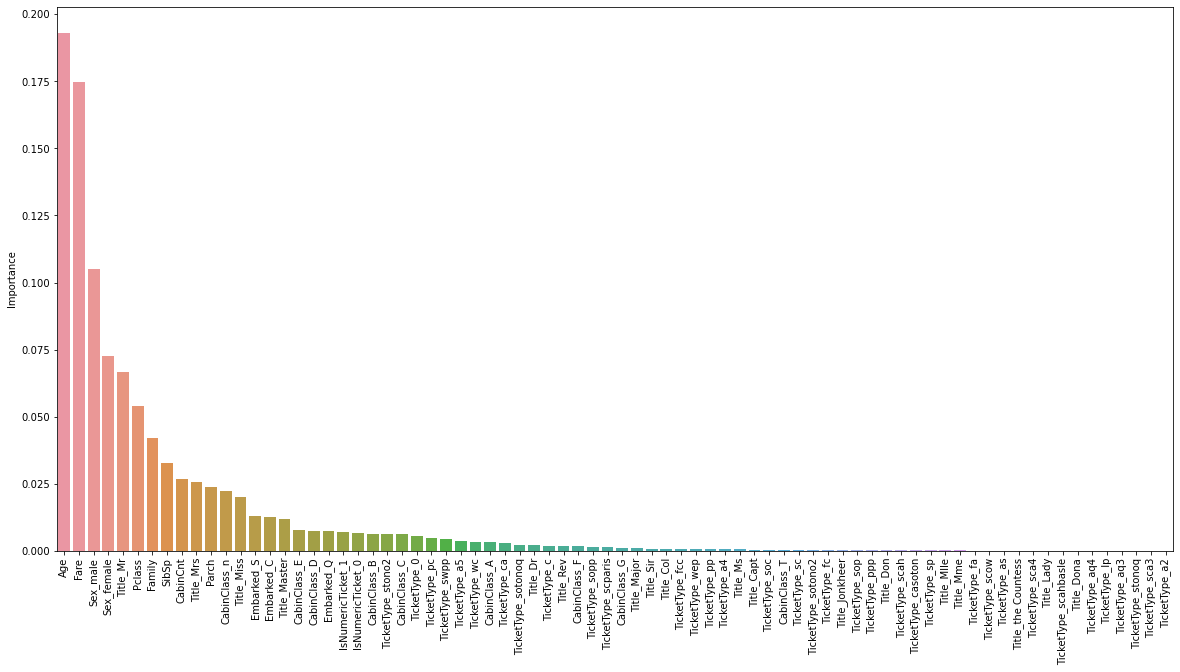

In [19]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
plt.show()

In [20]:
data.Title = data.Title.apply(lambda x: 'Others' if x in list(data.Title.value_counts()[data.Title.value_counts() < 8].index) else x)
data.TicketType = data.TicketType.apply(lambda x: 'Others' if x in list(data.TicketType.value_counts()[data.TicketType.value_counts() < 10].index) else x)

In [21]:
# split data2
data_dummies = pd.get_dummies(data)
X_train = data_dummies[data_dummies.IsTrain == 1].drop(['IsTrain'], axis=1)
X_test = data_dummies[data_dummies.IsTrain == 0].drop(['IsTrain'], axis=1)

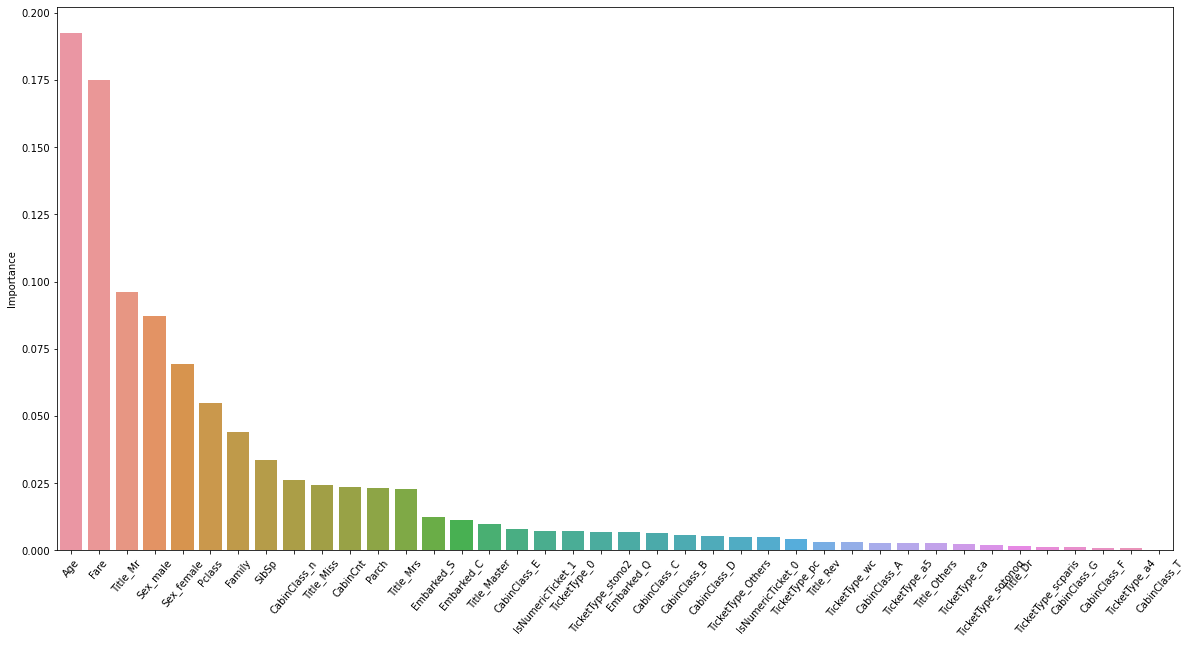

In [22]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 50)
plt.show()

# Modeling

In [23]:
allow_tuning = False

In [24]:
def xgb_gridsearch(params_grid_xgb, features, values, X, y, last=False):
    x_train, x_test = train_test_split(X, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y, test_size=.2, random_state=42)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    model_xgb = XGBClassifier(use_label_encoder = False, 
                              objective = 'binary:logistic')
    
    for i in range(len(features)):
        params_grid_xgb[features[i]] = values[i]
    search_xgb = GridSearchCV(model_xgb, params_grid_xgb, verbose = 0,
                              scoring = 'neg_log_loss', cv = cv).fit(x_train, y_train_tmp, early_stopping_rounds = 15, 
                                  eval_set = [[x_test, y_test_tmp]], 
                                  eval_metric = 'logloss', verbose = False)
    for i in range(len(features)):
        print(f"{features[i]}: {search_xgb.best_params_[features[i]]}")
    for k, v in search_xgb.best_params_.items():
        search_xgb.best_params_[k] = [v]
    if last:
        for k, v in search_xgb.best_params_.items():
            search_xgb.best_params_[k] = v[0]
    return search_xgb, search_xgb.best_params_

In [25]:
if allow_tuning:
    params_knn = {
        'n_neighbors' : range(1, 10),
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree','kd_tree'],
        'p' : [1,2]
    }
    model_knn = knn()
    search_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_knn.best_params_)

In [26]:
if allow_tuning:
    params_logistic = {
        'max_iter': [2000],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
    model_logistic = LogisticRegression()
    search_logistic = GridSearchCV(model_logistic, params_logistic, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_logistic.best_params_)

In [27]:
if allow_tuning:
    params_svc = [{'kernel': ['rbf'], 'gamma': [.01, .1, .5, 1, 2, 5, 10], 'C': [.1, 1, 10, 100, 1000], 'probability': [True]},
                  {'kernel': ['poly'], 'degree' : [2, 3, 4, 5], 'C': [.01, .1, 1, 10, 100, 1000], 'probability': [True]}]
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

In [28]:
if allow_tuning:
    params_svc = {'kernel': ['rbf'], 'gamma': [i/10000 for i in range(90, 110)], 'C': range(50, 80, 10), 'probability': [True]}
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

In [29]:
if allow_tuning:
    params_rf = {
        'n_estimators': range(100, 2000, 200),
        'criterion':['gini','entropy'],
        'bootstrap': [True, False],
        'max_depth': list(range(5, 100, 5)) + [None],
        'max_features': ['auto','sqrt', 5, 10],
        'min_samples_leaf': range(2, 11, 2),
        'min_samples_split': range(2, 11, 2)}
    model_rf = RandomForestClassifier()
    search_rf = RandomizedSearchCV(model_rf, params_rf, cv=5,
                                   scoring='accuracy', n_jobs=-1, verbose=1,
                                   n_iter=100).fit(X_train, y_train)
    print(search_rf.best_params_)

In [30]:
if allow_tuning:
    params_rf = {
        'n_estimators': [95, 100, 105],
        'criterion':['entropy'],
        'bootstrap': [True, False],
        'max_depth': [40, 45, 50],
        'max_features': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [9, 10, 11]}
    model_rf = RandomForestClassifier()
    search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    search_rf.best_params_ = 734
    print(search_rf.best_params_)

In [31]:
if allow_tuning:
    params_xgb = {'n_estimators': [1000],
                  'learning_rate': [0.1],
                  'max_depth': [5],
                  'min_child_weight': [1],
                  'gamma': [0],
                  'subsample': [0.8],
                  'colsample_bytree': [0.8],
                  'n_jobs': [-1],
                  'objective': ['binary:logistic'],
                  'use_label_encoder': [False],
                  'eval_metric': ['logloss'],
                  'scale_pos_weight': [1]}

    search_xgb, params_xgb = xgb_gridsearch(params_xgb, 
                                            ['learning_rate'], 
                                            [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['max_depth', 'min_child_weight'],
                                            [range(3, 10), range(1, 6)],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['gamma'],
                                            [[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['subsample', 'colsample_bytree'],
                                            [[i/100.0 for i in range(75,90,5)], [i/100.0 for i in range(75,90,5)]],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['reg_alpha'], 
                                            [[1e-5, 1e-2, 0.1, 1, 100]], 
                                            X_train, y_train)
    params_xgb['n_estimators'] = [5000]
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['learning_rate'],
                                            [[0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train, last=True)

    x_train, x_test = train_test_split(X_train, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y_train, test_size=.2, random_state=42)
    model_xgb = XGBClassifier(**params_xgb)
    model_xgb = model_xgb.fit(x_train, y_train_tmp, eval_set=[(x_test, y_test_tmp)], eval_metric=['logloss'], early_stopping_rounds=15, verbose=0)
    search_xgb.best_estimator_.n_estimators = model_xgb.best_iteration

each models

In [32]:
if allow_tuning:
    model_knn = search_knn.best_estimator_
    model_logistic = search_logistic.best_estimator_
    model_svc = search_svc.best_estimator_
    model_rf = search_rf.best_estimator_
    model_xgb = search_xgb.best_estimator_
else:
    model_knn = knn(algorithm='auto', 
                    n_neighbors=9,
                    p=1, 
                    weights='uniform')
    
    model_logistic = LogisticRegression(C=0.08858667904100823,
                                        max_iter=2000, 
                                        penalty='l2', 
                                        solver='liblinear')
    model_svc = SVC(C=70,
                    gamma=0.0106,
                    kernel='rbf',
                    probability=True)
    
    model_rf = RandomForestClassifier(bootstrap=True,
                                      criterion='entropy',
                                      max_depth=50, max_features=6, 
                                      min_samples_leaf=1, 
                                      min_samples_split=10, 
                                      n_estimators=100,
                                      random_state=734)
    
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.8,
                              enable_categorical=False, eval_metric='logloss', gamma=0.4,
                              gpu_id=-1, importance_type=None, interaction_constraints='',
                              learning_rate=0.07, max_delta_step=0, max_depth=5,
                              min_child_weight=1, missing=np.nan, monotone_constraints='()',
                              n_estimators=37, n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8, tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=0)

models = {
    'knn': model_knn,
    'logistic': model_logistic,
    'svc': model_svc,
    'rf': model_rf,
    'xgb': model_xgb
}

voting models

In [33]:
import copy

def select_models(start, cnt, goal, estimators, voting):
    if cnt == goal:
        estimators_copy = copy.deepcopy(estimators)
        voting_name = f'{voting}_' + '_'.join([i[0] for i in list(estimators_copy)])
        models[voting_name] = VotingClassifier(estimators=estimators_copy, voting=voting)
        return
    for i in range(start, 5):
        estimators.append(list(models.items())[i])
        select_models(i + 1, cnt + 1, goal, estimators, voting)
        estimators.pop()
        

In [34]:
select_models(0, 0, 2, [], 'hard')
select_models(0, 0, 3, [], 'hard')
select_models(0, 0, 4, [], 'hard')
select_models(0, 0, 5, [], 'hard')

select_models(0, 0, 2, [], 'soft')
select_models(0, 0, 3, [], 'soft')
select_models(0, 0, 4, [], 'soft')
select_models(0, 0, 5, [], 'soft')

cross validation scores

In [35]:
result_by_model = pd.DataFrame({'model name': models.keys(), 'model': models.values(), 'score': 0})

In [36]:
for name, model in models.items():
    result_by_model.loc[result_by_model['model name'] == name, 'score'] = cross_val_score(model, X_train,y_train,cv=5).mean()

In [37]:
result_by_model.sort_values('score', ascending=False)

,model name,model,score
22,hard_logistic_svc_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.840291
13,hard_svc_xgb,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.835790
19,hard_knn_svc_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.834666
2,svc,"SVC(C=70, gamma=0.0106, probability=True)",0.833562
12,hard_svc_rf,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.833549
29,hard_logistic_svc_rf_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.833530
18,hard_knn_svc_rf,"VotingClassifier(estimators=[('knn', KNeighbor...",0.832432
21,hard_logistic_svc_rf,"VotingClassifier(estimators=[('logistic',\n ...",0.831302
30,hard_knn_logistic_svc_rf_xgb,"VotingClassifier(estimators=[('knn', KNeighbor...",0.831296
37,soft_logistic_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.831289


In [38]:
model_name = 'rf'
models[model_name].fit(X_train, y_train)
y_pred = models[model_name].predict(X_test).astype('int')

submission = pd.DataFrame({'PassengerId': test.PassengerId, 
                              'Survived': y_pred})

submission.to_csv('submission.csv', index = False)